# Interactive dEB light curve "quick" fitting tool

In [22]:
# A vain attempt to suppress excessive TF info/warn messages
%env TF_CPP_MIN_LOG_LEVEL 2

env: TF_CPP_MIN_LOG_LEVEL=2


In [1]:
import sys
from pathlib import Path
import re
from ast import literal_eval
from itertools import zip_longest
from copy import deepcopy

import numpy as np
import astropy.units as u
from mocpy import MOC
from astroquery.vizier import Vizier
import lightkurve as lk
from uncertainties import UFloat

#%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from deblib import limb_darkening
from ebop_maven.estimator import Estimator
from libs import lightcurves, pipeline, plots, jktebop

2025-03-20 12:11:11.531346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 12:11:11.531976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 12:11:11.534378: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 12:11:11.540897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742472671.552675   11748 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742472671.55

<img src="https://www.aanda.org/articles/aa/full_html/2025/02/aa52325-24/aa52325-24-fig3.jpg" alt="Image by Nascimbeni et al. (2025)" width="750"/>

The PLATO LOPS2 long-pointing field as defined by [Nascimbeni et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025A&A...694A.313N) with the HEALPix grids published at [zenodo](https://zenodo.org/records/14720127). 

In [2]:
# MOC (multi-order coverage map) for querying the full LOPS2 field (regardless of the ncam coverage)
lops_moc = MOC.load(path="libs/data/lops2-footprints-moc/PLATOfootprint_hpix9_full_v2.fits")

In [3]:
tess_ebs_catalog = Vizier(catalog="J/ApJS/258/16", row_limit=1)
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

Estimator loading '/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-New-Ext0-bP-4096-None-500k'.
The model CNN-New-Ext0-bP-4096-None-500k was created at 2025-02-17T20:48:17+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


E0000 00:00:1742472673.804785   11748 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1742472673.805081   11748 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Select the target 
You can select from the TESS-ebs targets within the LOPS2 field or specify your own target.

The `target` is the object name value used on plots, messages and local cache folder.
The `search_term` is used to search for assets in MAST, which can be the target name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value).

In [4]:
tebs_lops = lops_moc.query_vizier_table("J/ApJS/258/16")
tebs_opts = [(f"{t['TIC']} (Morph={t['Morph']:.3f}; Per={t['Per']:.3f} d)", t['TIC'])
          for t in tebs_lops[(tebs_lops["Morph"] < 0.5) & (tebs_lops["Per"] > 2.0) & (tebs_lops["Per"] < 28.0)]]

display(VBox(children=[
    (_tebs_targs := Dropdown(description="TESS-ebs :", options=tebs_opts, value="0201497357", layout={'width': "max-content"})),
    HBox(children=[
        (target_text := Text(description="target :", value="", placeholder="target name or TIC")),
        (do_prefix := Checkbox(description="prefix search term with V* unless TIC",
                               value=True, layout={'width': "max-content"} )),
    ]),
]))

dl = dlink((_tebs_targs, 'value'), (target_text, 'value'))

### Review Target Information and refine the search

In [5]:
target = f"TIC {int(target_text.value):d}" if target_text.value.isnumeric() else target_text.value
search_term = f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target
print(f"The chosen target is '{target}' with search_term '{search_term}'")

# Find any assets for the target, filtered on TESS timeseries observations
search_results = lk.search_lightcurve(search_term)
suitable_mask = ((search_results.author == "SPOC") | (search_results.author == "TESS-SPOC")) \
                    & (search_results.table["dataproduct_type_products"] == "timeseries") \
                    & (search_results.table["obs_collection_products"] != "HLSP") \
                    & np.where(["TESS" in m for m in search_results.mission], True, False)

# Give use chance to select/deselect sectors and set the flux column and quality bitmask
target_box = Accordion(children=[
    VBox(children=(sec_checks := 
        [Checkbox(description="toggle all", value=True, indent=False)] + 
        [Checkbox(description=f"{r.mission[0]} ({r.year[0]}): author={r.author[0]}, target={r.target_name[0]}, exptime={r.exptime[0]}",
                  value=True, indent=False, layout={'width': "max-content"}) for r in search_results[suitable_mask]]
    )),
    HBox(children=[
        (flux_column := widgets.Dropdown(description="flux_column :", options=["sap_flux", "pdcsap_flux"], value="sap_flux", style={'description_width': 'max-content'})),
        (quality_bitmask := widgets.Dropdown(description="quality_bitmask :", options=["default", "hard", "hardest"], value="hardest", style={'description_width': 'max-content'})),
    ])
], titles=[f"Sectors found for {target}", "Flux column and quality bitmask"])

def toggle_all(_):
    for cb in sec_checks[1:]: cb.value = sec_checks[0].value
sec_checks[0].observe(toggle_all)
target_box.selected_index = 0
display(target_box)

The chosen target is 'TIC 201497357' with search_term 'TIC 201497357'


Accordion(children=(VBox(children=(Checkbox(value=True, description='toggle all', indent=False), Checkbox(valu…

### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [6]:
select_mask = np.array([sec_checks[i].value for i in range(1, len(sec_checks))], dtype=bool)
num_sectors = sum(select_mask)
target_file_stem = re.sub(r"[^\w\d]", "-", target.lower())
lcs = lightcurves.load_lightcurves(search_results[suitable_mask][select_mask], quality_bitmask.value,
                                   flux_column.value, Path.cwd() / ".cache" / target_file_stem)

### Plot the selected light curves

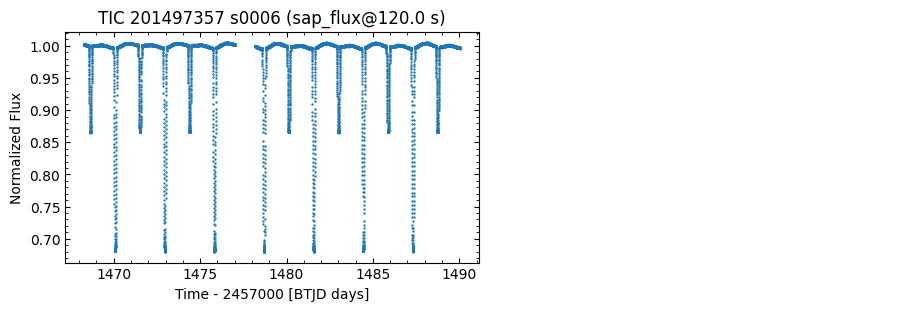

In [7]:
lcs_titles = [f"{target} s{l.sector:04d} ({l.meta['FLUX_ORIGIN']}@{l.meta['FRAMETIM']*l.meta['NUM_FRM']} s)" for l in lcs]
plt.show(fig := plots.plot_lightcurves(lcs, "flux", lcs_titles, normalize_lcs=True))
plt.close(fig)

### Process the light curves to create flattened copies with delta_mag columns

First we select regions to exclude from processing. These could be distorted regions of the
light curve, incomplete eclipses or isolated regions with no useful data. Currently there is
no tool for selecting ranges from the light curve plot directly, so instead we parse the text
of an exclude list of (from, to) time tuples taken from all sectors. For example;
```python
[(1420.0, 1424.0), (2158.0, 2160.0)]
```
where the time values are interpreted with the time format and scale of each light curve.

Once we have any time masks we can use these, along with a simple mask which excludes
invalid flux values, to create masked copies of the original light curves. The masked
light curves are then extended with `delta_mag` and `delta_mag_err` columns calculated
from the fluxes. The `delta_mag` values are detrended and rectified in contiguous segments,
which are selected by finding gaps in the timeseries > gap threshold. Each segment is
rectified and detrended by subtracting a fitted polynomial of the selected degree. 

In [8]:
display(VBox(children=[
    (combine_sectors := Checkbox(description=f"Combine {num_sectors} sector(s)", value=False, indent=False, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    (time_masks_text := Text(description="Time ranges to exclude:", placeholder="[(from, to), (from, to), ...]", layout={'width': "50%"}, style={'description_width': 'max-content'})),
    (seg_gap_th := FloatLogSlider(description="segment gap threshold (d):", base=10, value=2.0, min=-1, max=3, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    HBox(children=[
        (poly_degr := IntSlider(description="detrend poly degree:", value=1, min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (dtrd_iters := IntSlider(description="detrend iterations:", value=2, min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
])]))

In [9]:
time_mask_list = []
if len(time_masks_text.value.strip()): # Interpret the list of (from, to) tuples entered above
    time_mask_list = literal_eval(time_masks_text.value)
    if isinstance(time_mask_list, (tuple, int, float)):
        time_mask_list = [time_mask_list]

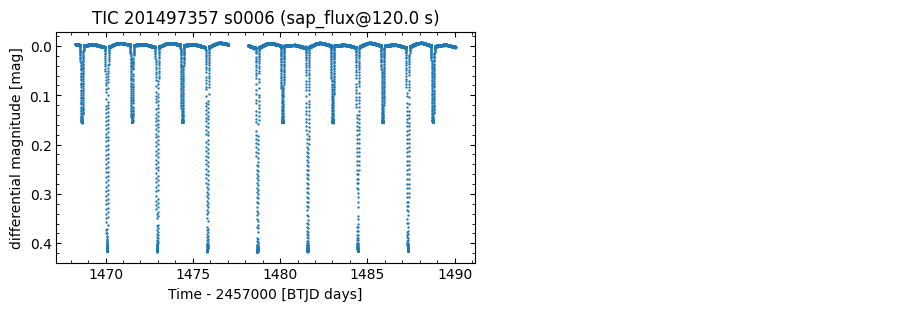

In [10]:
mag_lcs = lk.LightCurveCollection([])
if combine_sectors.value and len(lcs):
    _norm_lcs = [lcs.stitch(lambda lc: lc.normalize())]
    lcs_titles = [f"{target} over {num_sectors} sector(s)"]
else:
    _norm_lcs = (lc.normalize() for lc in lcs)
    
for norm_lc in _norm_lcs:
    # Mask out any invalid fluxes and requested time ranges
    qual_mask = lightcurves.create_invalid_flux_mask(norm_lc)
    for time_mask_range in (lightcurves.to_lc_time(t, norm_lc) for t in time_mask_list):
        qual_mask &= (norm_lc.time < np.min(time_mask_range)) | (norm_lc.time > np.max(time_mask_range))
    norm_lc = norm_lc[qual_mask]

    # Create detrended & rectified delta_mag and delta_mag err columns
    lightcurves.append_magnitude_columns(norm_lc, "delta_mag", "delta_mag_err")
    for s in lightcurves.find_lightcurve_segments(norm_lc, threshold=seg_gap_th.value * u.d):
        norm_lc[s]["delta_mag"] -= lightcurves.fit_polynomial(norm_lc.time[s], norm_lc[s]["delta_mag"],
                                                              poly_degr.value, dtrd_iters.value, 1.0)
    mag_lcs.append(norm_lc)
del _norm_lcs

plt.show(fig := plots.plot_lightcurves(mag_lcs, "delta_mag", lcs_titles))
plt.close(fig)

### Review phase folded light curves
First we lookup for the system's ephemeris in the TESS-ebs catalogue based on its TIC. If nothing found then the primary epoch and orbital period must be set manually by inspecting the light curves above.

By default the T0 time is expected to be the time of a primary eclipse. The phase folded light curves will be phase normalized when folded about this point (which becomes phase 0).

In [11]:
default_t0, default_period = None, None
if (result := tess_ebs_catalog.query_object(mag_lcs[0].meta["OBJECT"])):
    default_t0, default_period = result[0]["BJD0"][0], result[0]["Per"][0]
elif (result := gaia_tbosb_catalog.query_object(search_term)):
    default_period = result[0]["Per"][0]

display(HBox(children=[
    (t0_text := FloatText(description="Primary epoch (btjd):",  value=default_t0, style={'description_width': 'max-content'})),
    (period_text := FloatText(description="Orbital period (d):", value=default_period, style={'description_width': 'max-content'})),
    (double_check := Checkbox(description="Use orbital period x2", value=False, style={"description_width": "max-content"})),
]))

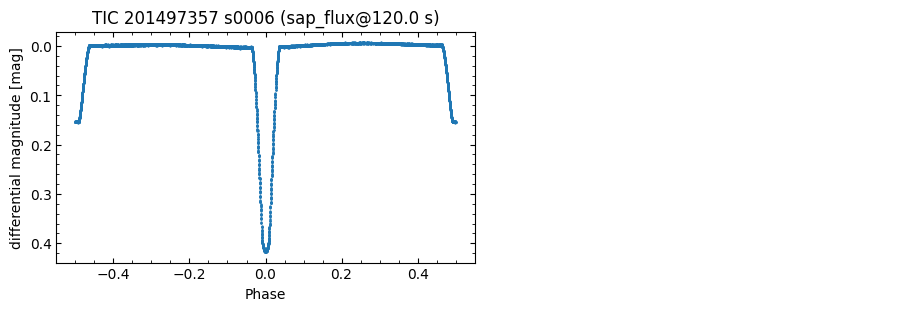

In [12]:
t0 = lightcurves.to_lc_time(t0_text.value, mag_lcs[0])
period = (2 if double_check.value else 1) * (period_text.value * u.d)

# Plot folded copies of the mags LCs. By default lk will give these phase ranges [-0.5, 0.5]
# which works well here as we want to be able to judge the phase of the secondary eclipses.
fig = plots.plot_lightcurves([*(lc.fold(period, t0, normalize_phase=True) for lc in mag_lcs)], "delta_mag", lcs_titles)
plt.show(fig)
plt.close(fig)

### Create sampled, phase folded mags data for use with EBOP MAVEN
We now need to make sampled copies of phase folded & phase normalized light curves for
each sector. The EBOP MAVEN model will tell us what wrap it expects for the folded light curves
for estimations through its `mags_feature_wrap_phase` attribute. This will have a value between
0 and 1, or `None`;
- a numeric value indicates the phase above which phased data is wrapped
to a negative phase
    - a value of 0.75 indicates a phase range of -0.24999 to 0.75, centred on phase 0.25
- a value of `None` indicates the wrap is to ensure the resulting data is centred on the
mid-point between the primary and secondary eclipse
    - in this case the value must be found by inspection of the light curves above or from a known value
    - for a circular orbit a value of 0.75 centres the data at this mid-point (phase 0.25)

In [13]:
mags_wrap_phase = estimator.mags_feature_wrap_phase
if mags_wrap_phase is None:
    display(HBox(children=[
        (wrap_phase_slider := FloatSlider(description="Mags feature wrap phase:", value=.75, min=.01, max=.99, step=.01,
                                          layout={"width": "33%"}, style={'description_width': 'max-content'})),
    ]))

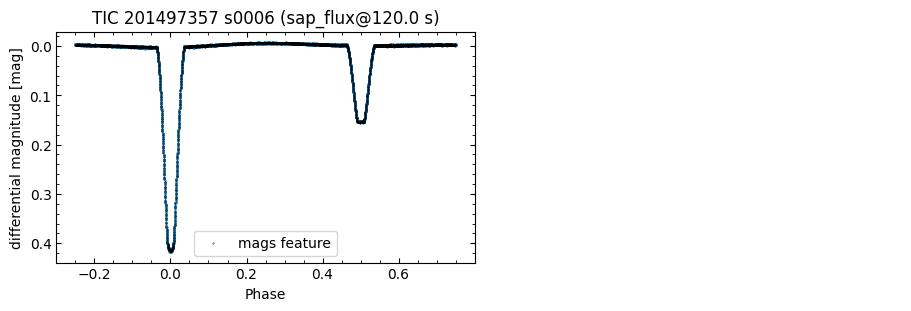

In [14]:
mags_bins = estimator.mags_feature_bins
if mags_wrap_phase is None:
    mags_wrap_phase = u.Quantity(wrap_phase_slider.value)
elif not isinstance(mags_wrap_phase, u.Quantity):
    mags_wrap_phase = u.Quantity(mags_wrap_phase)

flcs = []
samp_mags = np.zeros(shape=(len(mag_lcs), 2, mags_bins), dtype=np.float32)
for ix, lc in enumerate(mag_lcs):
    flcs.append(flc := lc.fold(period, t0, wrap_phase=mags_wrap_phase, normalize_phase=True))
    samp_mags[ix] = lightcurves.get_sampled_phase_mags_data(flc, mags_bins, mags_wrap_phase)

def _plot_sample(ix, ax):
    ax.scatter(samp_mags[ix, 0], samp_mags[ix, 1], s=0.33, c="k", marker=".", label="mags feature")

fig = plots.plot_lightcurves(flcs, "delta_mag", lcs_titles, ax_func=_plot_sample, legend_loc="lower center")
plt.show(fig)
plt.close(fig)

### Estimate fitting input parameters with EBOP MAVEN
The EBOP MAVEN model will predict values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ for use as `JKTEBOP` fitting input parameters. To these we will
need to add values for $i$, which can be calculated from the 6 predicted values.

In [15]:
predictions = estimator.predict(samp_mags[:, 1], iterations=1000)
predictions = pipeline.append_calculated_inc_predictions(predictions, "inc")

for lc, preds in zip(mag_lcs, predictions):
    print(f"\nJKTEBOP input parameters for {target} sector {lc.meta['SECTOR']}")
    print(*(f"{p:>12s}: {preds[p] or 0:11.6f}" for p in predictions.dtype.names), sep="\n")


JKTEBOP input parameters for TIC 201497357 sector 6
  rA_plus_rB:    0.232009+/-   0.007124
           k:    0.574701+/-   0.016992
           J:    0.437227+/-   0.035948
       ecosw:    0.001576+/-   0.005673
       esinw:   -0.006339+/-   0.016911
          bP:    0.222520+/-   0.022982
         inc:   88.133048+/-   0.204658


### Estimate limb darkening parameters
We have starting effective temperature and surface gravity values in the
TESS metadata stored with the light curves, however this refers to system
as a whole. We use J as a simple proxy for the ratio of effective temperatures.

In [16]:
def_temp, def_log = mag_lcs[0].meta.get("TEFF", 5800), mag_lcs[0].meta.get("LOGG", 4.0)
J = np.mean(predictions["J"]).nominal_value
display(VBox(children=[
    HBox(children=[
        (teffA_text := FloatSlider(description="Effective temp star A (K):", value=def_temp, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggA_text := FloatSlider(description="log(g) star A (dex):", value=def_log, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),    
    ]),
    HBox(children=[
        (teffB_text := FloatSlider(description="Effective temp star B (K):", value=def_temp * J, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggB_text := FloatSlider(description="log(g) star A (dex):", value=def_log, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),
    ]),
]))

In [17]:
ldA_coeffs = limb_darkening.lookup_pow2_coefficients(loggA_text.value, teffA_text.value)
ldB_coeffs = limb_darkening.lookup_pow2_coefficients(loggB_text.value, teffB_text.value)
ld_params = {
    "LDA": "pow2", "LDA1": ldA_coeffs[0], "LDA2": ldA_coeffs[1],
    "LDB": "pow2", "LDB1": ldB_coeffs[0], "LDB2": ldB_coeffs[1],
}

### Perform JKTEBOP Task 3 analysis
First we set up the in and dat files for each analysis to be run.

In [18]:
# Superset of all of the potentially fitted parameters
all_fitted_params = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "rA", "rB"]
fitted_params = np.empty(shape=(len(mag_lcs), ),
                         dtype=[(k, np.dtype(UFloat.dtype)) for k in all_fitted_params])

In [19]:
task = 3
fit_dir = jktebop.get_jktebop_dir()
file_fmt = f"quick-fit-{target_file_stem}-{{sector:04d}}.{{ext:s}}"
for ix, (lc, preds) in enumerate(zip(mag_lcs, predictions)):
    in_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="in")
    dat_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="dat")
    par_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="par")

    in_params = {
        "task": task,
        "qphot": preds["k"]**1.4,
        "gravA": 0.,                "gravB": 0.,
        "L3": 0.,

        "reflA": 0.,                "reflB": 0.,
        "period": period.value,
        "primary_epoch": t0.value,
        
        "simulations": 100 if task == 8 else "",

        "qphot_fit": 0,
        "ecosw_fit": 1,             "esinw_fit": 1,
        "gravA_fit": 0,             "gravB_fit": 0,
        "L3_fit": 1,
        "LDA1_fit": 1,              "LDB1_fit": 1,
        "LDA2_fit": 0,              "LDB2_fit": 0,
        "reflA_fit": 1,             "reflB_fit": 1,
        "sf_fit": 1,
        "period_fit": 1,            "primary_epoch_fit": 1,

        "data_file_name": dat_fname.name,
        "file_name_stem": dat_fname.stem,

        **{ n: preds[n] for n in preds.dtype.names },
        **ld_params,
    }

    # JKTEBOP will fail if it finds files from a previous fitting
    for file in fit_dir.glob(file_fmt.format(sector=lc.meta["SECTOR"], ext="*")):
        file.unlink()
    segments = lightcurves.find_lightcurve_segments(lc, 0.5, yield_times=True)
    append_lines = jktebop.build_poly_instructions(segments, "sf", 1) + ["", "chif", ""]
    jktebop.write_in_file(in_fname, append_lines=append_lines, **in_params)
    jktebop.write_light_curve_to_dat_file(lc, dat_fname)

    # Blocks on the JKTEBOP task until we can parse the newly written par file contents
    # to read out the revised values for the superset of potentially fitted parameters.
    pgen = jktebop.run_jktebop_task(in_fname, par_fname, stdout_to=sys.stdout)
    for k, v in jktebop.read_fitted_params_from_par_lines(pgen, all_fitted_params, True).items():
        fitted_params[ix][k] = v

  
JKTEBOP  v43  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-tic-201497357-0006.par                  
>> Opened new LC output  file:  quick-fit-tic-201497357-0006.out                  
>> Opened new model fit  file:  quick-fit-tic-201497357-0006.fit                  
>> Read  14588 datapoints (with errors) from file quick-fit-tic-201497357-0006.dat                  
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 26 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:  11.526 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best fit has been found after 12 iterations.
  


#### Report of JKTEBOP fitting results

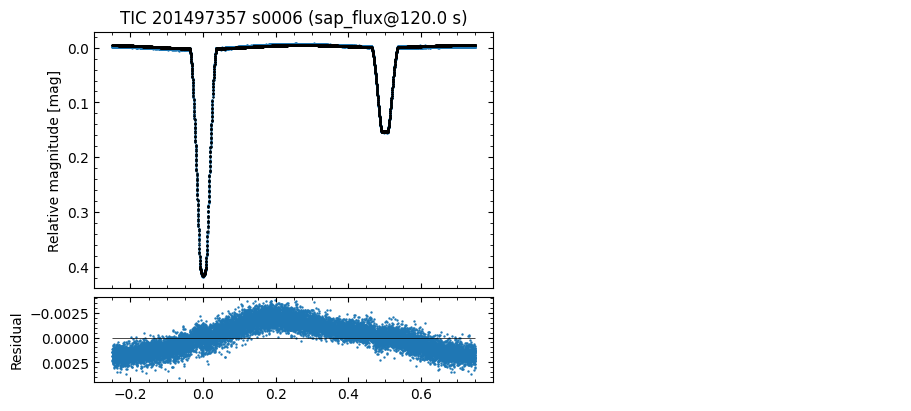

In [20]:
if task == 3:
    rows, cols = int(np.ceil(len(mag_lcs) / 2)), 2
    fig, axes = plt.subplots(rows*2, cols, figsize=(4.5*cols, 4*rows), height_ratios=(3, 1)*rows, constrained_layout=True)

    for ix in range(axes.size//2):
        row, col = int(np.floor(ix / cols) * 2), ix % cols
        ax_lc, ax_res = axes[row, col], axes[row+1, col]
        if ix < len(mag_lcs):
            # Pick columns so they are ordered [phase, lc_mag, model_mag, residual]
            out_file = fit_dir / file_fmt.format(sector=mag_lcs[ix].meta['SECTOR'], ext="out")
            out_data = np.loadtxt(out_file, float, comments="#", usecols=[3, 1, 4, 5], unpack=True)
            out_data[0][out_data[0] > mags_wrap_phase.value] -= 1. # matches wrap used previously
        
            if ix < len(mag_lcs):
                ax_lc.scatter(out_data[0], out_data[1], s=2.0, marker=".", label=None)
                ax_lc.scatter(out_data[0], out_data[2], s=0.5, c="k", marker=".", label=None)
                ax_res.scatter(out_data[0], out_data[3], s=2.0, marker=".", label=None)
                ax_res.hlines([0.0], min(out_data[0]), max(out_data[0]), ls="-", color="k", lw=.5)

                if ix == 0:
                    ax_lc.invert_yaxis()
                    ax_res.invert_yaxis()
                else:
                    ax_lc.sharey(axes[0, 0])
                    ax_res.sharey(axes[1, 0])
        
                # Hides tick labels on inner facing shared axes
                plt.setp(ax_lc.get_xticklabels(), visible=False) 
                if col > 0:
                    plt.setp(ax_lc.get_yticklabels(), visible=False)
                    plt.setp(ax_res.get_yticklabels(), visible=False)
                plots.format_axes(ax_lc, title=lcs_titles[ix], ylabel="" if ix % cols else "Relative magnitude [mag]")
                plots.format_axes(ax_res, ylabel="" if ix % cols else "Residual")
        else:
            ax_lc.axis("off")
            ax_res.axis("off")
    plt.show(fig)
    plt.close(fig)

In [21]:
print("Mean f" if len(fitted_params) > 1 else "F" + f"itted parameter values for {target} over {num_sectors} sector(s)")
for param in fitted_params.dtype.names:    
    print(f"{param:>12s}: {np.mean(fitted_params[param]) or 0:11.6f}")

Fitted parameter values for TIC 201497357 over 1 sector(s)
  rA_plus_rB:    0.231345+/-   0.000096
           k:    0.582967+/-   0.001859
           J:    0.474831+/-   0.003910
       ecosw:    0.000186+/-   0.000015
       esinw:    0.001110+/-   0.000696
         inc:   87.926833+/-   0.039434
          L3:    0.003764+/-   0.004750
          pe: 1470.082143+/-   0.000018
      period:    2.872135+/-   0.000005
          rA:    0.146147+/-          0
          rB:    0.085199+/-          0
